# Preparation
Open a terminal on your node, e.g. ```ssh bitcoin@raspberrypi```. The user (here 'bitcoin') must have access to the lightning daemons commandline interface. 

Make a directory and move into it.
```
mkdir ln-data && cd $_
```
Information that your node has collected through gossip about other nodes and channels can be output through cli commands. We will redirect the output to files to evaluate it later.
```
lightning-cli listnodes > nodes.json
lightning-cli listchannels > channels.json
```
There are many other commands that provide interesting information (see https://lightning.readthedocs.io). 
Of course, it works the same way for LND. The commands and the output are just slightly different.

Now switch to your local machine and copy the directory from the remote to the directory of this notebook, e.g.
```
scp -r bitcoin@raspberrypi:~/ln-data /path/to/this/notebook/here
```

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

Load node data

In [3]:
data = pd.read_json("./ln-data/nodes.json", orient='record')
nodes = pd.DataFrame.from_records(data['nodes'])
nodes.head()

,nodeid,alias,color,last_timestamp,features,addresses,option_will_fund
0,02529db69fd2ebd3126fb66fafa234fc3544477a23d509...,🚀🌑 BOLTENING.club,4286f5,1.679614e+09,8000000000000000000000000000000000000000000000...,"[{'type': 'ipv4', 'address': '195.201.174.171'...",NaN
1,0290cc884704073b2b633f69f852e8ca2a37660bb359a1...,HeldenLight,0000aa,1.679668e+09,8000000000000000000000000000000000000000000000...,"[{'type': 'ipv4', 'address': '5.9.94.237', 'po...",NaN
2,0358327cb80ab2a8db36a5924c62966c7b4a753045600d...,Johoe,3399ff,1.679649e+09,8000000000000000000000000000000000000000000000...,"[{'type': 'ipv4', 'address': '88.198.39.205', ...",NaN
3,03da1c27ca77872ac5b3e568af30673e599a47a5e4497f...,LNBiG.com🇺🇦[lnd-26/lnd-07],3399ff,1.679642e+09,8000000000000000000000000000000000000000000000...,"[{'type': 'ipv4', 'address': '213.174.156.70',...",NaN
4,03328dba4e263835416d35b14a2f0298f567c6bb5dad7e...,katana🗡,ffb3fd,1.679691e+09,8000000000000000000000000000000000000000000000...,"[{'type': 'ipv4', 'address': '160.86.139.5', '...",NaN


Load channel data

In [4]:
data = pd.read_json("./ln-data/channels.json", orient='record')
channels = pd.DataFrame.from_records(data['channels'])
channels.head()

,source,destination,short_channel_id,public,satoshis,amount_msat,message_flags,channel_flags,active,last_update,base_fee_millisatoshi,fee_per_millionth,delay,htlc_minimum_msat,htlc_maximum_msat,features
0,02529db69fd2ebd3126fb66fafa234fc3544477a23d509...,0290cc884704073b2b633f69f852e8ca2a37660bb359a1...,533973x699x0,True,10000000,10000000000msat,1,0,True,1679253814,1,8,64,1msat,10000000000msat,
1,0290cc884704073b2b633f69f852e8ca2a37660bb359a1...,02529db69fd2ebd3126fb66fafa234fc3544477a23d509...,533973x699x0,True,10000000,10000000000msat,1,1,True,1679441080,1000,1,144,1000msat,10000000000msat,
2,0358327cb80ab2a8db36a5924c62966c7b4a753045600d...,03da1c27ca77872ac5b3e568af30673e599a47a5e4497f...,558568x504x0,True,9000000,9000000000msat,1,0,True,1679443236,100000,1000,144,1000msat,8910000000msat,
3,03da1c27ca77872ac5b3e568af30673e599a47a5e4497f...,0358327cb80ab2a8db36a5924c62966c7b4a753045600d...,558568x504x0,True,9000000,9000000000msat,1,1,True,1679510735,0,8,40,1000msat,8910000000msat,
4,03328dba4e263835416d35b14a2f0298f567c6bb5dad7e...,03afa7a8196dbca763ee6f9a34b634a7adc03f154e5d69...,762831x907x1,True,10000000,10000000000msat,1,0,True,1679223128,1000,500,40,1000msat,100000000msat,


Summarize channel data per node 

In [5]:
channels_summary = channels.groupby('source').agg({'destination':'count', 'satoshis': 'sum', 'last_update':'max' }).reset_index().rename(columns={'destination':'channel_count',
'satoshis':'sats_sum', 'source':'nodeid'})

channels_summary = pd.merge(channels_summary, nodes, on='nodeid', how='left')[['alias','nodeid','last_timestamp','channel_count','sats_sum','last_update']]
channels_summary.head()

,alias,nodeid,last_timestamp,channel_count,sats_sum,last_update
0,pay.lnrouter.app,0200000000a3eff613189ca6c4070c89206ad658e28675...,1.667731e+09,7,33169420,1679599780
1,BJCR_BTCPayServer,020003b9499a97c8dfbbab6b196319db37ba9c37bccb60...,1.679618e+09,35,239776475,1679701410
2,AlasPoorYorick,020016201d389a44840f1f33be29288952f67c8ef6b3f9...,1.679672e+09,12,31020000,1679698602
3,nodl-lnd-s010-042,02001828ca7eb8e44d4d78b5c1ea609cd3744be823c22c...,1.679675e+09,2,200000,1679671518
4,a8933f1a19c6,02001bcff2e27f6aa2aa8e68c7e5944bcbf5daf4954963...,1.679673e+09,1,90000,1679348943


<AxesSubplot:xlabel='channel_count', ylabel='sats_sum'>

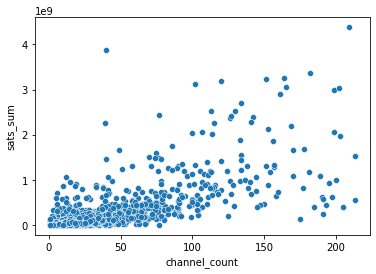

In [6]:
channels_summary_filtered = channels_summary[(np.abs(stats.zscore(channels_summary[['channel_count','sats_sum']])) < 3)]
sns.scatterplot(data=channels_summary_filtered, x="channel_count", y="sats_sum")

In [18]:
channels_summary['rank_channel'] = channels_summary.channel_count.rank(method='dense', ascending=False)
channels_summary['rank_capa'] = channels_summary.sats_sum.rank(method='dense', ascending=False)
channels_summary['sum_rank'] = channels_summary['rank_channel']+channels_summary['rank_capa']
channels_summary.sort_values('sum_rank').head()

,alias,nodeid,last_timestamp,channel_count,sats_sum,last_update,rank_channel,rank_capa,sum_rank
7159,ACINQ,03864ef025fde8fb587d989186ce6a4a186895ee44a926...,1.677236e+09,2811,49074083837,1679703424,1.0,2.0,3.0
4437,Kraken 🐙⚡,02f1a8c87607f415c8f22c00593002775941dea48869ce...,1.679696e+09,1440,34423971972,1679703200,5.0,5.0,10.0
5830,bfx-lnd0,033d8656219478701227199cbd6f670335c8d408a92ae8...,1.679657e+09,1148,89323172581,1679703164,9.0,1.0,10.0
6424,WalletOfSatoshi.com,035e4ff418fc8b5554c5d9eea66396c227bd429a3251c8...,1.679622e+09,2480,19091179825,1679703204,2.0,9.0,11.0
6867,ln.nicehash.com [Nicehash],037659a0ac8eb3b8d0a720114efc861d3a940382dcfa14...,1.679702e+09,1389,20824421859,1679703509,6.0,7.0,13.0


<AxesSubplot:xlabel='satoshis', ylabel='Count'>

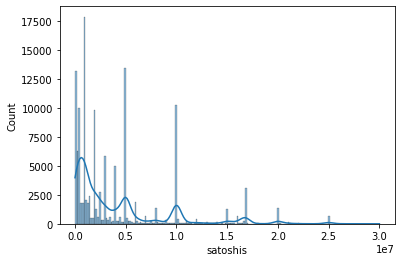

In [24]:
smallchannels = channels[channels['satoshis'] < 30000000]
sns.histplot(data=smallchannels,x='satoshis', kde=True)